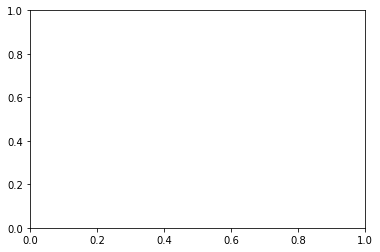

In [1]:
import pandas as pd
import matplotlib as mpl
mpl.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from navipy.trajectories import Trajectory
import os
# Data will be split into training, test, and validation set
from sklearn.model_selection import train_test_split 

# We will use classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# And need to report the classification
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

#
from multiprocessing import Pool
import tqdm

import joblib

## Saccade | Intersaccade from body

The goal is the same as the one exposed in chap_06a_SaccadeIntersaccades_Example, i.e. find a method to determine whether the flight is performing a head saccade solely based on the body change in orientation. 

1. Classifiers will be trained on all flights (except flight 05, kept for validation of the best classifier). 
2. Hyperparameters of the classifiers, window-size and depth will be tested in a grid search manner
3. The best classifiers will be selected
4. The performance of the classifiers will be validated on flight 05

In [2]:
# Load list of flights
head_filename_result = 'chapter_1_results/head_thorax_data.h5'
flight_ids = pd.read_hdf(head_filename_result,key='flight_ids')
# Load the results from splitted nonans
head_filename_result_blocknonans =  'chapter_1_results/head_thorax_data_blk.h5'

## On all data (except flightid 05 - for validation)

In [3]:
validflight = '17'
traintestflights = flight_ids.loc[flight_ids!=validflight]

In [4]:
def merge_dictdata(dictdata):
    merged_df = dict()
    for col in ['x','y','b']:
        merged_df[col] = dict()
        for bid, val in dictdata.items():
            tomerge = dict()
            for blk, df in val.items():
                if col in df.keys():
                    tomerge[blk] = df[col]
            merged_df[col][bid] = pd.concat(tomerge)
        merged_df[col] = pd.concat(merged_df[col])
    return merged_df

In [5]:
def prepare_data(selectedflights, n,test_size, head_filename_result_blocknonans, verbose=True):
    """ Prepare the data according to step above until classification
    """
    train_data = dict()
    test_data = dict()
    for flightid in selectedflights:
        if verbose:
            print(flightid+' - ',end='')
        train_data[flightid] = dict()
        test_data[flightid] = dict()
        # Read block no nans
        key = '/blk_nonans/flight_{}'.format(flightid) 
        blknonans = pd.read_hdf(head_filename_result_blocknonans,key)

        for blk_i in blknonans.index:
            if verbose:
                print(blk_i,',',end='')
            train_data[flightid][blk_i] = dict()
            test_data[flightid][blk_i] = dict()
            # 1 - Load the data
            # 1a - thorax
            key = '/velocities_filtered/flight_{}/blk_{}'.format(flightid,blk_i) 
            body_velocity = pd.read_hdf(head_filename_result_blocknonans,key).loc[:,'thorax']
            body_velocity.dropna(inplace=True)
            # 1b - Ground truth
            key = '/res_sac/flight_{}/blk_{}'.format(flightid,blk_i) 
            res_sac_head = pd.read_hdf(head_filename_result_blocknonans,key).loc[:,'head']
            if res_sac_head.shape[0]<=2*n:
                continue
            # 1c - benchmark
            res_sac_body = pd.read_hdf(head_filename_result_blocknonans,key).loc[:,'thorax']
            # 3 - Format data
            # 3a - target
            intersaccade = res_sac_head.loc[body_velocity.index].saccade.isnull()
            target = intersaccade.copy()
            # 3b - observations
            observation = body_velocity.zyx.dalpha_2.copy() # angular vel around z axis
            list_of_values = []
            a = observation.rolling(n, center=True).apply(lambda x: list_of_values.append(x.values) or 0, raw=False)
            observations = pd.DataFrame(list_of_values, index=a.dropna().index, columns=np.arange(n)-n//2)
            # Lets check that we did not do a mess
            # the observations at time shift 0, should match the observation at the same index
            assert np.all(observations.loc[:,0] == observation.loc[observations.index]), \
                "Problem with building observations"
            # 3c - Select target to have two align matrices
            target = target.loc[observations.index]
            # 3d - benchmark
            benchmark = res_sac_body.loc[target.index].saccade.isnull()

            # 3f - Split
            split = train_test_split(target, test_size=test_size, shuffle=False) # shuffle false because first/last part of flight
            train_data[flightid][blk_i]['x'] = observations.loc[split[0].index]
            train_data[flightid][blk_i]['y'] = target.loc[split[0].index]
            train_data[flightid][blk_i]['b'] = benchmark.loc[split[0].index]
            
            test_data[flightid][blk_i]['x'] = observations.loc[split[1].index]
            test_data[flightid][blk_i]['y'] = target.loc[split[1].index]
            test_data[flightid][blk_i]['b'] = benchmark.loc[split[1].index]
        if verbose:
            print(end='\n')
    # Merge
    train_df = merge_dictdata(train_data)
    test_df = merge_dictdata(test_data)
    return train_df, test_df

### Hyperparameters grid search

* window_size: the number of frame used around the point to be predicted
* maxdepth: the number of leaves in the classifiers.

In [6]:
window_size = np.arange(1,52,2)
maxdepth = np.arange(1,21,1)
[ws,md] = np.meshgrid(window_size,maxdepth)
print(ws.size,' hyperparamters combinations will be tested')

520  hyperparamters combinations will be tested


In [7]:
def trained_classifiers(ws, 
                        traintestflights=traintestflights,
                        head_filename_result_blocknonans=head_filename_result_blocknonans, 
                        test_size = 0.3):
    score_classifier_dtree = pd.DataFrame(index=[ws], columns=maxdepth, dtype=float)
    score_classifier_rforest = score_classifier_dtree.copy()
    score_benchmark = pd.Series(index=[ws], dtype=float)
    # Preapre data
    train_df, test_df = prepare_data(traintestflights, ws, 
                                     test_size, head_filename_result_blocknonans,
                                     verbose=False)
    score_benchmark.loc[ws] = accuracy_score(test_df['y'], test_df['b'])
    for md in maxdepth:
        clf = DecisionTreeClassifier(max_depth=md, random_state=1234)
        clf.fit(train_df['x'].values, train_df['y'].values)
        pred_y = clf.predict(test_df['x'].values)
        score_classifier_dtree.loc[ws,md] = accuracy_score(test_df['y'], pred_y)

        clf = RandomForestClassifier(max_depth=md, n_estimators=100, random_state=1234)
        clf.fit(train_df['x'].values, train_df['y'].values)
        pred_y = clf.predict(test_df['x'].values)
        score_classifier_rforest.loc[ws,md] = accuracy_score(test_df['y'], pred_y)
    return score_classifier_dtree, score_classifier_rforest, score_benchmark

# We use multiprocessing to speed up a bit the calculations
with Pool(processes=8) as pool:
    result = []
    for res in tqdm.tqdm(pool.imap_unordered(trained_classifiers, window_size), total=len(window_size)):
        result.append(res)

100%|██████████| 26/26 [12:46<00:00, 29.48s/it]


Merge results

In [8]:
score_classifier_dtree = pd.concat([res[0] for res in result])
score_classifier_rforest = pd.concat([res[1] for res in result])
score_benchmark = pd.concat([res[2] for res in result])

In [9]:
score_classifier_dtree = score_classifier_dtree.sort_index().transpose().sort_index().transpose()
score_classifier_rforest = score_classifier_rforest.sort_index().transpose().sort_index().transpose()

## Save best model (flight 17)

In [10]:
bestparam_dtree = score_classifier_dtree.astype(float).unstack().idxmax()
bestparam_dtree = pd.Series(bestparam_dtree,index=['maxdepth','window_size'])

bestparam_rforest = score_classifier_rforest.astype(float).unstack().idxmax()
bestparam_rforest = pd.Series(bestparam_rforest,index=['maxdepth','window_size'])

In [11]:
ws = bestparam_dtree.window_size
md = bestparam_dtree.maxdepth
# Prepare data
train_df, test_df = prepare_data(traintestflights, ws,
                                head_filename_result_blocknonans=head_filename_result_blocknonans, 
                                test_size = 0.3,verbose=False)
# Train 
clf = DecisionTreeClassifier(max_depth=md, random_state=1234)
clf.fit(train_df['x'].values, train_df['y'].values)
# save the classifier
_ = joblib.dump(clf, 'chapter_3_results/best_decisiontree.pkl', compress=9)

# Random forest
ws = bestparam_rforest.window_size
md = bestparam_rforest.maxdepth
# Prepare data
train_df, test_df = prepare_data(traintestflights, ws, 
                                 head_filename_result_blocknonans=head_filename_result_blocknonans, 
                                test_size = 0.3,verbose=False)
# Train 
clf = RandomForestClassifier(max_depth=md, n_estimators=100, random_state=1234)
clf.fit(train_df['x'].values, train_df['y'].values)
# save the classifier
_ = joblib.dump(clf, 'chapter_3_results/best_randomforest.pkl', compress=9)

### Where the results will be saved

In [12]:
fname_results = 'chapter_3_results/classification_comparison.h5'

### Save results

In [13]:
with pd.HDFStore(fname_results) as hdf:
    hdf.put('/scores/dtree',score_classifier_dtree.astype(float))
    hdf.put('/scores/rforest',score_classifier_rforest.astype(float))
    hdf.put('/scores/benchmark',score_benchmark.astype(float))
    hdf.put('/best/rforest',bestparam_rforest.astype(float))
    hdf.put('/best/dtree',bestparam_dtree.astype(float))
    
    